In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

In [116]:
df = pd.read_csv('TSLA.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


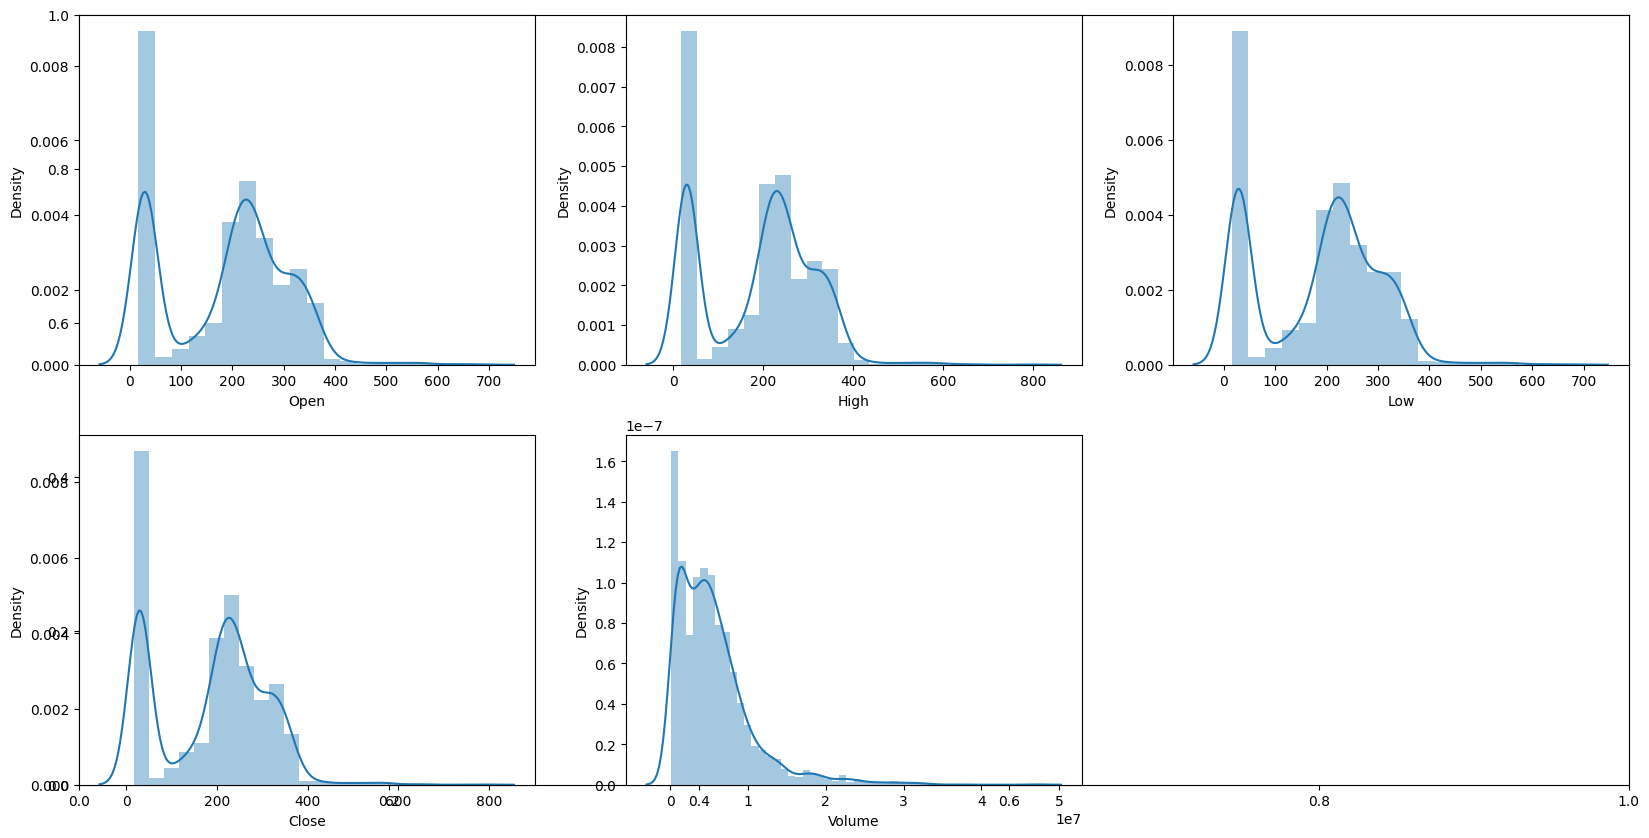

In [117]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

In [118]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [119]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Adj Close']])

In [120]:
future_days = 10
epochs = 50
batch_size = 32
n_steps = 60

In [121]:
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [122]:
model1 = Sequential([
            SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
            Dense(1)
        ])




In [123]:
model1.compile(optimizer='adam', loss='mean_squared_error')


In [124]:
es1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [125]:
history = model1.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[es1],
                verbose=1
            )

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0117 - val_loss: 0.0040
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.9135e-04 - val_loss: 0.0033
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9349e-04 - val_loss: 0.0029
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4803e-04 - val_loss: 0.0027
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.1280e-04 - val_loss: 0.0024
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0384e-04 - val_loss: 0.0024
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7840e-04 - val_loss: 0.0020
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6430e-04 - val_loss: 0.0020
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6163e-04 - val_loss: 0.0017
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4177e-04 - val_loss: 0.0018
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0912e-04 - val_loss: 0.0015
Epoch 12/50
59/59 ━━━━━

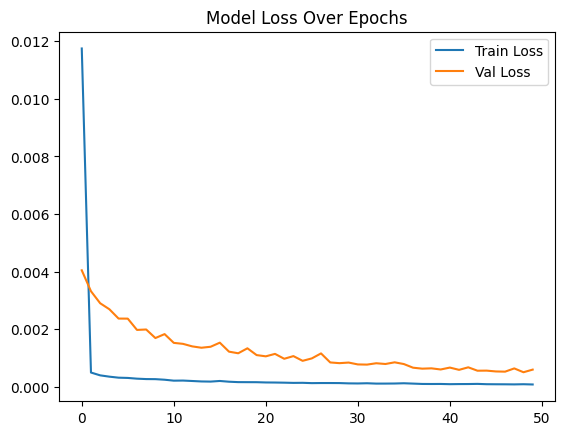

In [126]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Val Loss')
ax.set_title("Model Loss Over Epochs")
ax.legend()


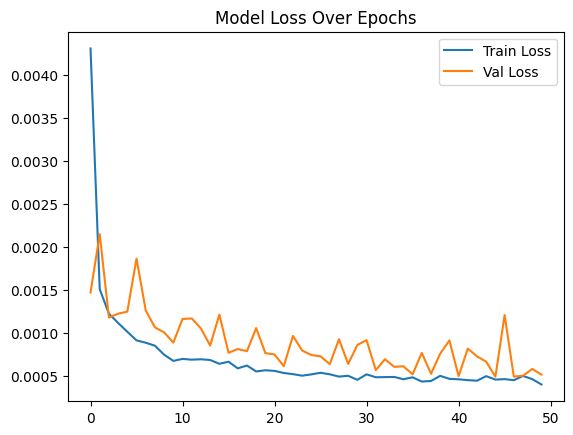

In [127]:
fig, ax = plt.subplots()
ax.plot(history2.history['loss'], label='Train Loss')
ax.plot(history2.history['val_loss'], label='Val Loss')
ax.set_title("Model Loss Over Epochs")
ax.legend()

In [128]:
last_sequence = scaled_data[-n_steps:]
predictions = []
for _ in range(future_days):
    X_pred = last_sequence.reshape((1, n_steps, 1))
    pred = model1.predict(X_pred, verbose=0)
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred)

In [129]:
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
future_dates = [df.index[-1] + timedelta(days=i+1) for i in range(future_days)]

forecast_df = pd.DataFrame({
"Date": future_dates,
"Predicted Price": predicted_prices.flatten()
        })

In [130]:
forecast_df.head(10)

,Date,Predicted Price
0,2020-02-04,647.811768
1,2020-02-05,692.888733
2,2020-02-06,628.159363
3,2020-02-07,627.053650
4,2020-02-08,594.395874
5,2020-02-09,591.692505
6,2020-02-10,575.778381
7,2020-02-11,567.314270
8,2020-02-12,548.696228
9,2020-02-13,542.788879


Text(0.5, 1.0, 'Stock Price Forecast (Next 10 Days)')

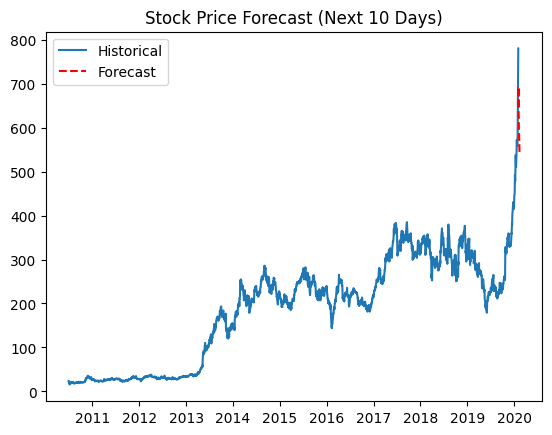

In [140]:
fig, ax = plt.subplots()
ax.plot(df.index, df['Adj Close'], label='Historical')
ax.plot(forecast_df['Date'], forecast_df['Predicted Price'], 'r--', label='Forecast')
ax.legend()
ax.set_title("Stock Price Forecast (Next 10 Days)")

In [133]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape= (n_steps, 1)))
model2.add(Dropout(0.2)) # Dropout after the first LSTM layer
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2)) # Dropout after the first LSTM layer
model2.add(Dense(25))
model2.add(Dropout(0.2)) # Dropout after the first LSTM layer
model2.add(Dense(1))

In [134]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [135]:
es2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [136]:
history2 = model2.fit(
    X_train,
    y_train,
    epochs=50,  # A large number of epochs, as early stopping will manage the duration
    batch_size=32,
    validation_data=(X_test, y_test),  # Required for monitoring validation loss
    callbacks=[es2]
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 9.5055e-04 - val_loss: 0.0017
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 9.5812e-04 - val_loss: 0.0011
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 9.2718e-04 - val_loss: 0.0011
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 8.6032e-04 - val_loss: 0.0013
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 8.5804e-04 - val_loss: 0.0013
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 8.2707e-04 - val_loss: 0.0011
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 7.3262e-04 - val_loss: 9.8356e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 7.2393e-04 - val_loss: 8.8643e-04
Epoch 12/50
59/59 ━━

In [137]:
last_sequence2 = scaled_data[-n_steps:]
predictions2 = []
for _ in range(future_days):
    X_pred2 = last_sequence2.reshape((1, n_steps, 1))
    pred2 = model2.predict(X_pred2, verbose=0)
    predictions2.append(pred2[0, 0])
    last_sequence2 = np.append(last_sequence2[1:], pred2)

Text(0.5, 1.0, 'Stock Price Forecast (Next 10 Days)')

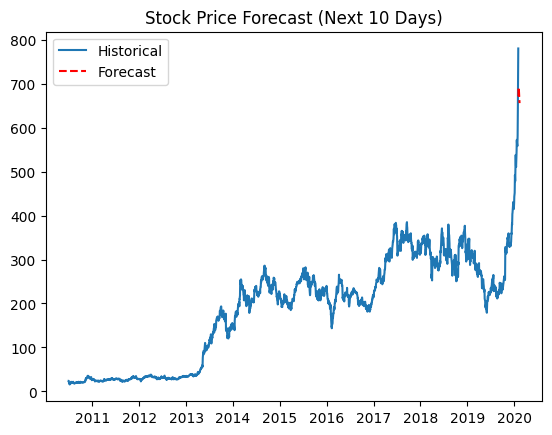

In [141]:
fig2, ax2 = plt.subplots()
ax2.plot(df.index, df['Adj Close'], label='Historical')
ax2.plot(forecast_df2['Date'], forecast_df2['Predicted Price'], 'r--', label='Forecast')
ax2.legend()
ax2.set_title("Stock Price Forecast (Next 10 Days)")

In [ ]:
predicted_prices2 = scaler.inverse_transform(np.array(predictions2).reshape(-1, 1))
future_dates2 = [df.index[-1] + timedelta(days=i+1) for i in range(future_days)]

forecast_df2 = pd.DataFrame({
"Date": future_dates,
"Predicted Price": predicted_prices2.flatten()
        })

In [139]:
forecast_df2.head(10)

,Date,Predicted Price
0,2020-02-04,671.312012
1,2020-02-05,688.755554
2,2020-02-06,691.996277
3,2020-02-07,689.493530
4,2020-02-08,684.639893
5,2020-02-09,678.872559
6,2020-02-10,672.847778
7,2020-02-11,666.887146
8,2020-02-12,661.155518
9,2020-02-13,655.733032
